In [1]:
import polars as pl
import functools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit, minimize, least_squares
from IPython.display import clear_output
from matplotlib import ticker


In [2]:
def get_noise_label(hybrid_mixing_shift):
    if hybrid_mixing_shift == 0.0:
        return "balanced"
    if hybrid_mixing_shift <= -1e2:
        return "masked"
    if hybrid_mixing_shift >= 1e2:
        return "uniform"
    if hybrid_mixing_shift < 0:
        return "low-uniform"
    if hybrid_mixing_shift > 0:
        return "high-uniform"

colors = {
    -1000.0: (58, 76, 192),
    -2.0: (141, 175, 253),
    0.0: (122, 220, 121),
    2.0: (243, 152, 121),
    1000.0: (179, 3, 38),
}

In [3]:
df_ = pl.read_csv("losses.csv")

df_ = df_.filter(pl.col("batch_size") < 1024)
df_ = df_.group_by("hybrid_mixing_shift", "non_emb_params", "target_loss").agg(pl.all().sort_by("tokens").first())
df_ = df_.filter((pl.col("steps") <= 100000) & (pl.col("steps") > 5000)).sort("non_emb_params")

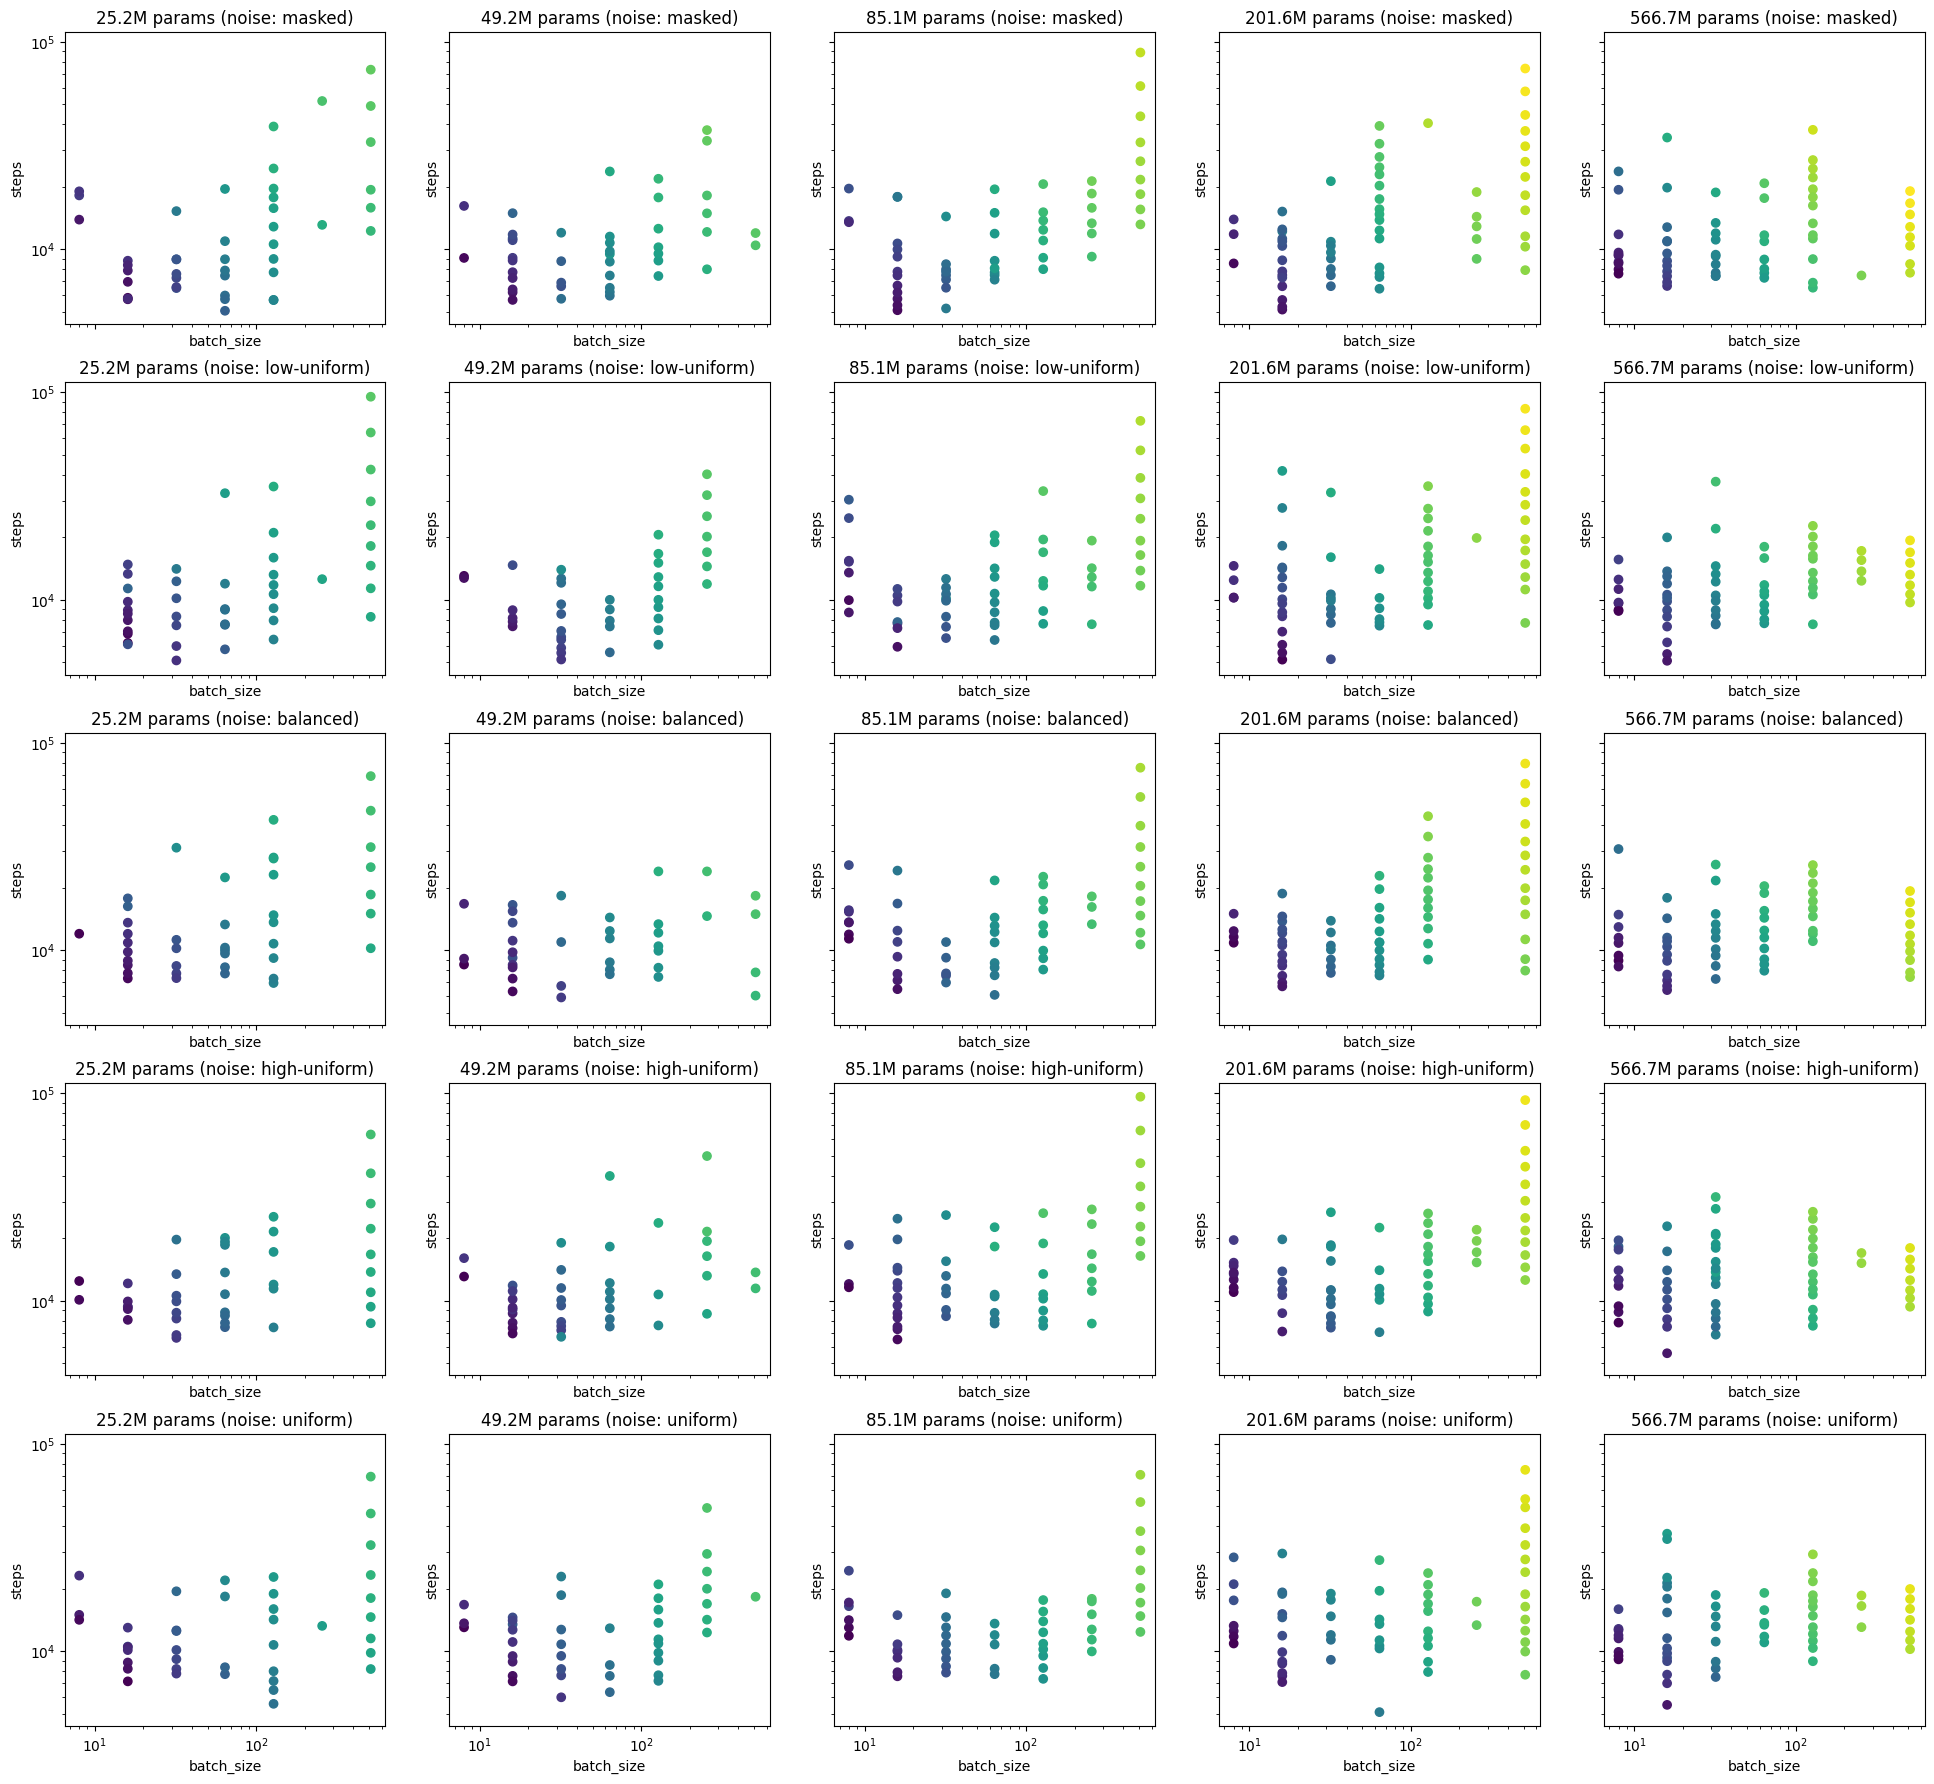

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x.clip(-10, 10)))

fig, axs = plt.subplots(5, len(df_["non_emb_params"].unique()), figsize=(24, 22), sharex=True, sharey=True)

vmin, vmax = df_["target_loss"].min(), df_["target_loss"].max()

for i, ((params, ), dfi) in enumerate(df_.group_by("non_emb_params")):
    for j, ((hybrid_mixing_shift, ), dfj) in enumerate(dfi.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
        ax = axs[j, i]
        # ax.scatter(dfj["batch_size"], dfj["steps"], c=sigmoid(dfj["hybrid_mixing_shift"]))
        ax.scatter(dfj["batch_size"], dfj["steps"], c=dfj["target_loss"], cmap="viridis_r", vmin=vmin, vmax=vmax)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("batch_size")
        ax.set_ylabel("steps")
        ax.set_title(f"{params/1e6:.1f}M params (noise: {get_noise_label(hybrid_mixing_shift)})")

In [6]:
scaling_laws = {}
fit_in_logspace = False


def hypothesis1(P, D, a, alpha, b, beta, E):
    return E + a * P**-alpha + b * D**-beta

for i, ((hybrid_mixing_shift, ), dfi) in enumerate(df_.sort("hybrid_mixing_shift").group_by("hybrid_mixing_shift")):
    P1, D1, L1 = dfi["non_emb_params"].to_numpy(), dfi["tokens"].to_numpy(), dfi["target_loss"].to_numpy()

    transform = lambda x: x
    if fit_in_logspace:
        transform = np.log

    def base_resid(f, y, p):
        return transform(f(*p)) - transform(y)

    resid1 = functools.partial(base_resid, functools.partial(hypothesis1, P1, D1), L1)
    
    p1_0 = (1.0,) * 5

    sol1 = least_squares(resid1, p1_0, bounds=(1e-8, np.inf), loss="huber")

    print(f"{get_noise_label(hybrid_mixing_shift):20s}: a={sol1.x[0]:.3g},\talpha={sol1.x[1]:.3g},\tb={sol1.x[2]:.3g},\tbeta={sol1.x[3]:.3g},\tE={sol1.x[4]:.3g}")

    scaling_laws[hybrid_mixing_shift] = {
        "func": hypothesis1,
        "resid": resid1,
        "args": (P1, D1),
        "y": L1,
        "p": sol1.x,
    }

masked              : a=52.2,	alpha=0.269,	b=644,	beta=0.314,	E=2.28
low-uniform         : a=40.2,	alpha=0.25,	b=448,	beta=0.293,	E=2.24
balanced            : a=30.7,	alpha=0.231,	b=327,	beta=0.274,	E=2.17
high-uniform        : a=12.3,	alpha=0.159,	b=378,	beta=0.283,	E=1.98
uniform             : a=8.48,	alpha=0.121,	b=369,	beta=0.281,	E=1.74


/var/folders/b_/6gztjjy15vq9brgmv41d128h0000gn/T/ipykernel_94995/2111211212.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


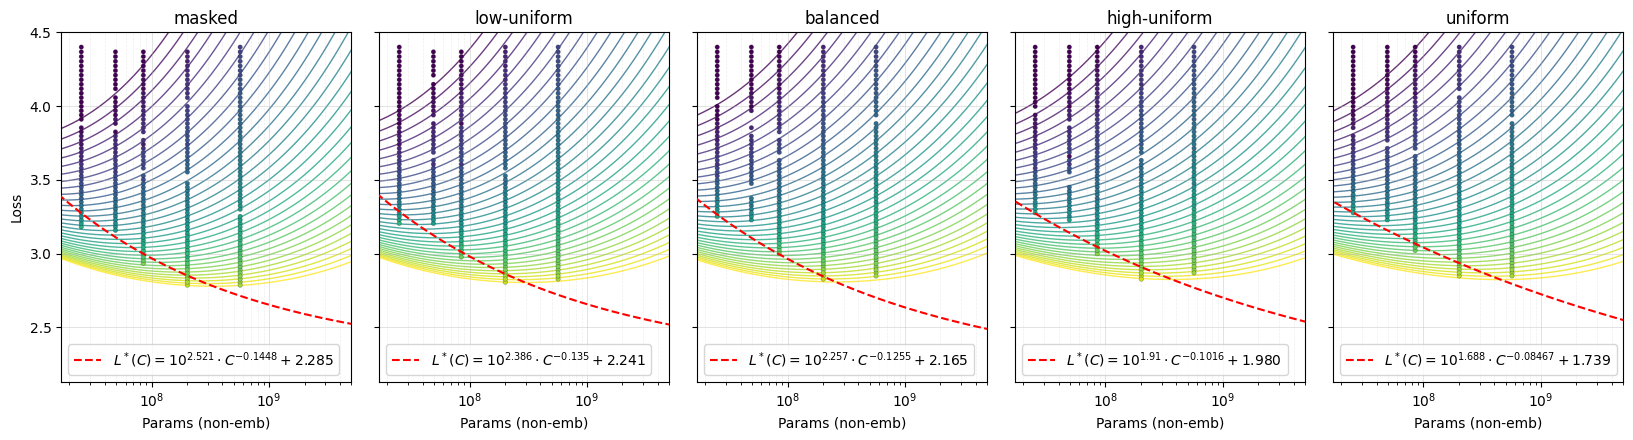

In [8]:

fig, axs = plt.subplots(1, 5, figsize=(17, 4.5), sharex=True, sharey="row")

flop_targets = np.logspace(17, np.log10(2e20), 32)

def color(x):
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(vmin=np.log(flop_targets).min(), vmax=np.log(flop_targets).max())
    return cmap(norm(np.log(x)))

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    ax = axs[i]
    for flops in flop_targets:
        params = np.logspace(7, 10, 100)
        tokens = flops / (6 * params)

        loss = scaling_law["func"](params, tokens, *scaling_law["p"])
        ax.plot(params, loss, color=color(flops), alpha=0.8, zorder=1, linewidth=1.0)

        batch_size = np.logspace(3, 7, 100)
        steps = flops / (6 * params[:, None] * batch_size[None, :])

        # loss = scaling_law["hypothesis3"]["func"](params[:, None], steps, batch_size[None, :], *scaling_law["hypothesis3"]["p"])
        # opt_loss = loss.min(axis=1)

        # opt_idx = loss.argmin()
        # ax.plot(params[opt_idx], loss[opt_idx], ".", color="red")

    dfi = df_.filter(pl.col("hybrid_mixing_shift") == hybrid_mixing_shift)
    xs = dfi["non_emb_params"]
    ys = dfi["target_loss"]
    c = dfi["tokens"] * xs * 6
    ax.scatter(xs, ys, c=np.log(c), cmap="viridis", vmin=np.log(flop_targets.min()), vmax=np.log(flop_targets.max()), edgecolor=(0, 0, 0, 0.3), linewidth=0.5, s=10, zorder=2)

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))
    L_star_P = E + a*(alpha + beta)/beta * params**(-alpha)
    ax.plot(params, L_star_P, linestyle="--", color="red", label="$L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E), zorder=3)

    ax.set_title(f"{get_noise_label(hybrid_mixing_shift)}")
    ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_ylim(None, 4.5)
    ax.set_xlim(1.7e7, 5e9)
    ax.legend()


    ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5, zorder=0)
    ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2, zorder=0)

for ax in axs.flatten():
    ax.set_xlabel("Params (non-emb)")

axs[0].set_ylabel("Loss")

fig.tight_layout(w_pad=-2.0)
fig.show()
#fig.savefig("plots/scaling_laws.pdf", dpi=300, bbox_inches="tight")

masked: $L^*(C) = 10^{2.478} \cdot C^{-0.1409} + 2.231$
low-uniform: $L^*(C) = 10^{2.462} \cdot C^{-0.1388} + 2.226$
balanced: $L^*(C) = 10^{2.277} \cdot C^{-0.1257} + 2.136$
high-uniform: $L^*(C) = 10^{2.087} \cdot C^{-0.1126} + 2.037$
uniform: $L^*(C) = 10^{1.869} \cdot C^{-0.09623} + 1.831$


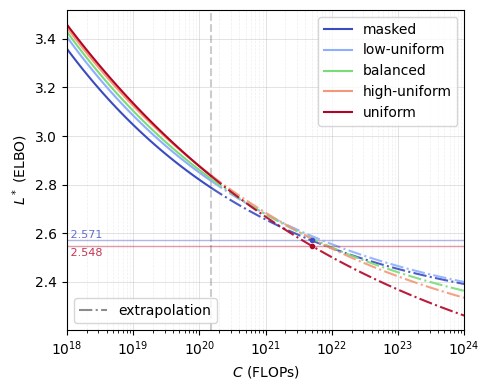

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

intra_flops = np.logspace(18, np.log10(1.5e20), 50)
extra_flops = np.logspace(np.log10(1.5e20), 24, 50)
flops = np.logspace(18, 24, 100)

idx = np.argmin(np.abs(flops - 1.5e20))

ax.axvline(x=1.5e20, color="gray", linestyle="--", alpha=0.4)
ax.plot([], [], linestyle="-.", color="gray", alpha=0.9, label="extrapolation")

for i, (hybrid_mixing_shift, scaling_law) in enumerate(scaling_laws.items()):
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    C_star_a = (alpha + beta) * (a/beta)**(beta/(alpha + beta)) * (b/alpha)**(alpha/(alpha + beta))
    C_star_alpha = (-(alpha*beta)/(alpha + beta))

    L_star_C_intra = E + C_star_a * (intra_flops/6)**C_star_alpha
    L_star_C_extra = E + C_star_a * (extra_flops/6)**C_star_alpha


    if hybrid_mixing_shift == -1000.0:
        C = 5e21
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0, alpha=0.8)

    
    if hybrid_mixing_shift == 1000.0:
        C = 5e21
        L = E + C_star_a * (C/6)**C_star_alpha
        ax.plot([C], [L], ".", color=np.array(color)/255.0, zorder=10)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.4, linewidth=1.0)
        ax.text(1e18, L*0.996, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0, alpha=0.8)

    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(intra_flops, L_star_C_intra, linestyle="-", color=np.array(color)/255.0, label=label)
    ax.plot(extra_flops, L_star_C_extra, linestyle="-.", color=np.array(color)/255.0, alpha=0.9)

    print(get_noise_label(hybrid_mixing_shift) + ": $L^*(C) = 10^{{{:.4g}}} \\cdot C^{{{:.4g}}} + {:.3f}$".format(np.log10(C_star_a), C_star_alpha, E))


handles, labels = ax.get_legend_handles_labels()
trend_mask = [lbl.startswith("extrapolation") for lbl in labels]
trend_handles = [h for h, m in zip(handles, trend_mask) if m]
trend_labels = [l for l, m in zip(labels, trend_mask) if m]
main_handles = [h for h, m in zip(handles, trend_mask) if not m]
main_labels = [l for l, m in zip(labels, trend_mask) if not m]

leg_main = ax.legend(main_handles, main_labels, loc="upper right")
ax.add_artist(leg_main)
ax.legend(trend_handles, trend_labels, loc="lower left")

ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlim(1e18, 1e24)

ax.set_xlabel("$C$ (FLOPs)")
ax.set_ylabel("$L^*$ (ELBO)")
fig.tight_layout()
#fig.savefig("plots/compute_optimal_frontier.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.551}, D^* \propto C^{0.449}
low-uniform: P^* \propto C^{0.53}, D^* \propto C^{0.47}
balanced: P^* \propto C^{0.548}, D^* \propto C^{0.452}
high-uniform: P^* \propto C^{0.603}, D^* \propto C^{0.397}
uniform: P^* \propto C^{0.654}, D^* \propto C^{0.346}


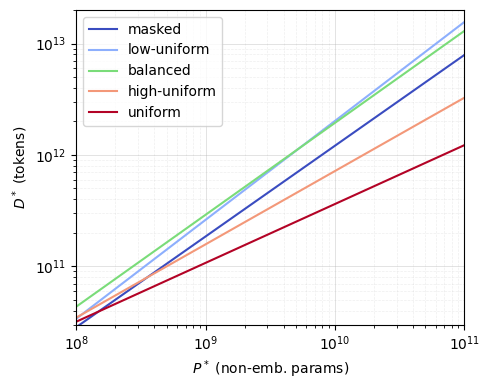

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)


    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

masked: P^* \propto C^{0.551}, D^* \propto C^{0.449}
low-uniform: P^* \propto C^{0.53}, D^* \propto C^{0.47}
balanced: P^* \propto C^{0.548}, D^* \propto C^{0.452}
high-uniform: P^* \propto C^{0.603}, D^* \propto C^{0.397}
uniform: P^* \propto C^{0.654}, D^* \propto C^{0.346}


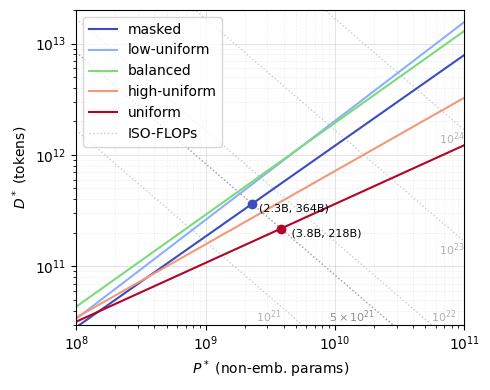

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

trained_flops = 5e21

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]


    a, alpha, b, beta, E = scaling_law["p"]
    P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    flops = np.logspace(18, 26, 100)
    params = P_star_a * (flops/6)**P_star_alpha
    tokens = D_star_a * (flops/6)**D_star_alpha

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(params, tokens, color=np.array(color)/255.0, label=label)
    
    if hybrid_mixing_shift == -1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"  ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    
    if hybrid_mixing_shift == 1000.0:
        P = P_star_a * (trained_flops/6)**P_star_alpha
        D = D_star_a * (trained_flops/6)**D_star_alpha
        ax.plot([P], [D], "o", color=np.array(color)/255.0)
        ax.text(P, D, f"   ({P/1e9:.1f}B, {D/1e9:.0f}B)", fontsize=8, va="top", ha="left")

    print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e8, 1e11)
ax.set_ylim(3e10, 2e13)

iso_flop_values = [1e21, 1e22, 1e23, 1e24]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = "ISO-FLOPs" if i == 0 else None
    ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.4, linewidth=1.0, zorder=0, label=label)
    x_label = x_max
    y_label = (C/6.0)/x_label
    ha = "right"
    va = "top"
    if y_label < y_min:
        va = "bottom"
        y_label = y_min
        x_label = (C/6.0)/y_label
        if C == 1e21:
            ha = "right"
            x_label = x_label * 0.7
        else:
            ha = "left"
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    ax.text(x_label, y_label, f"$10^{{{int(np.log10(C))}}}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.6)

iso_flop_values = [5e21]
for i, C in enumerate(iso_flop_values):
    y_line = (C/6.0) / x_line
    label = None
    ax.plot(x_line, y_line, linestyle=":", color="gray", alpha=0.8, linewidth=1.0, zorder=0, label=label)

    ha = "right"
    va = "bottom"
    y_label = y_min
    x_label = (C/6.0)/y_label * 0.73
    # if not (y_min < y_label < y_max):
    #     x_label = x_min*1.5
    #     y_label = (C/6.0)/x_label
    ax.text(x_label, y_label, "$5 \\times 10^{21}$", fontsize=8, va=va, ha=ha, color="gray", alpha=0.9)


ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$P^*$ (non-emb. params)")
ax.set_ylabel("$D^*$ (tokens)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend(loc="upper left")
fig.tight_layout()
#fig.savefig("plots/opt_params_tokens.pdf", bbox_inches="tight")

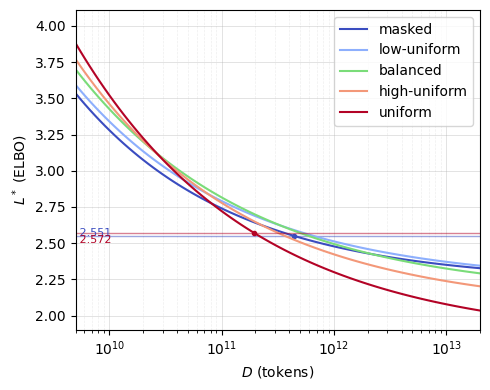

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

tokens = np.logspace(np.log10(1e9), np.log10(2e13), 100)

for hybrid_mixing_shift, scaling_law in scaling_laws.items():
    color = colors[hybrid_mixing_shift]

    a, alpha, b, beta, E = scaling_law["p"]
    # P_star_a, P_star_alpha = ((a*alpha)/(b*beta))**(1/(alpha + beta)), (beta/(alpha + beta))
    # D_star_a, D_star_alpha = ((b*beta)/(a*alpha))**(1/(alpha + beta)), (alpha/(alpha + beta))

    # flops = 6 * tokens * params
    # params = P_star_a * (flops/6)**P_star_alpha
    # tokens = D_star_a * (flops/6)**D_star_alpha
    L_star = E + ((alpha+beta)/alpha)*b * tokens**(-beta)

    # label = f"$P^* \\propto C^{{{P_star_alpha:.3g}}}$\n$D^* \\propto C^{{{D_star_alpha:.3g}}}$"
    label = get_noise_label(hybrid_mixing_shift)
    ax.plot(tokens, L_star, color=np.array(color)/255.0, label=label)

    if hybrid_mixing_shift == -1000.0:
        D = 440 * 1e9
        L = E + ((alpha+beta)/alpha)*b * D**(-beta)
        ax.plot([D], [L], ".", color=np.array(color)/255.0)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.5, linewidth=1.0)
        # ax.text(5e9, L, f" {L:.3f}", fontsize=8, va="bottom", ha="left")
        ax.text(5e9, L*0.995, f" {L:.3f}", fontsize=8, va="bottom", ha="left", color=np.array(color)/255.0)

    
    if hybrid_mixing_shift == 1000.0:
        D = 194 * 1e9
        L = E + ((alpha+beta)/alpha)*b * D**(-beta)
        ax.plot([D], [L], ".", color=np.array(color)/255.0)
        ax.axhline(y=L, color=np.array(color)/255.0, linestyle="-", alpha=0.5, linewidth=1.0)
        # ax.text(5e9, L, f" {L:.3f}", fontsize=8, va="top", ha="left")
        ax.text(5e9, L*0.995, f" {L:.3f}", fontsize=8, va="top", ha="left", color=np.array(color)/255.0)


    # print(f"{get_noise_label(hybrid_mixing_shift)}: P^* \\propto C^{{{P_star_alpha:.3g}}}, D^* \\propto C^{{{D_star_alpha:.3g}}}")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(5e9, 2e13)
ax.set_ylim(1.9, 4.11)

ax.grid(True, which="major", linestyle="-", linewidth=0.5, alpha=0.5)
ax.grid(True, which="minor", linestyle="--", linewidth=0.5, alpha=0.2)

ax.set_xlabel("$D$ (tokens)")
ax.set_ylabel("$L^*$ (ELBO)")
# ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), labelspacing=1.0)
ax.legend()
fig.tight_layout()
#fig.savefig("plots/opt_loss_vs_tokens.pdf", bbox_inches="tight")